# Reconstruction Sandbox
This notebook is a test-bed for regularization and reconstruction methods

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Load motiondeblur module and Dataset class
import libwallerlab.projects.motiondeblur as md
from libwallerlab.utilities.io import Dataset, isDataset

# Platform imports
import os, glob
from os.path import expanduser

# Debugging imports
import llops as yp
import matplotlib.pyplot as plt
import numpy as np

yp.config.setDefaultBackend('arrayfire')
yp.config.setDefaultDatatype('float32')

## Load Data

In [2]:
fig_output = '/Users/zfphil/Dropbox/Berkeley/Phase-Deblurring/fom2019/'

In [10]:
dataset_full_path = '/Users/zfphil/datasets/motiondeblur/01-17-19-MotionDeblur/beads_coded_raster_250_motion deblur_2019_01_17_18_48_08'

# Create dataset object (loads metadata)
dataset = Dataset(dataset_full_path)#'res' not in dataset_label)

# Force type to be motiondeblur
dataset.metadata.type = 'motiondeblur'

Loading 1 frames...


## Perform Registration and Normalization

In [14]:
force = True

# Perform registration
dataset.motiondeblur.register(force=force, frame_offset=-22, segment_offset=(15, -290), debug=False,
                              frame_registration_mode='xc', segment_registration_mode='xc')

# Perform normalization
dataset.motiondeblur.normalize(force=force)

# Perform kernel shape 
dataset.metadata.calibration['blur_vector'] = {'scale': {'axis': 1, 'factor': 1}}

Minimizing function:


<IPython.core.display.Latex object>

|  Iter  |      Cost      | Elapsed time (s) |  Norm of Step  | Memory Usage (CPU/GPU) |
+ ------ + -------------- + ---------------- + -------------- + ---------------------- +
|    0   |    1.64e+07    |       0.00       |    0.00e+00    |  360.8 MB / 2224.6 MB  |
|   10   |    1.66e+06    |       1.33       |    2.51e+02    |  361.0 MB / 2310.0 MB  |
|   20   |    1.20e+06    |       2.71       |    4.01e+02    |  361.0 MB / 2310.0 MB  |
|   30   |    8.92e+05    |       4.09       |    4.73e+02    |  361.0 MB / 2310.0 MB  |
|   40   |    6.77e+05    |       5.48       |    4.84e+02    |  361.0 MB / 2310.0 MB  |
|   50   |    5.23e+05    |       6.86       |    4.66e+02    |  361.0 MB / 2310.0 MB  |
|   60   |    4.14e+05    |       8.26       |    4.42e+02    |  361.0 MB / 2310.0 MB  |
|   70   |    3.33e+05    |       9.64       |    4.11e+02    |  361.0 MB / 2310.0 MB  |
|   80   |    2.75e+05    |      11.03       |    3.73e+02    |  361.0 MB / 2310.0 MB  |
|   90   |    2.30e+0

<IPython.core.display.Javascript object>


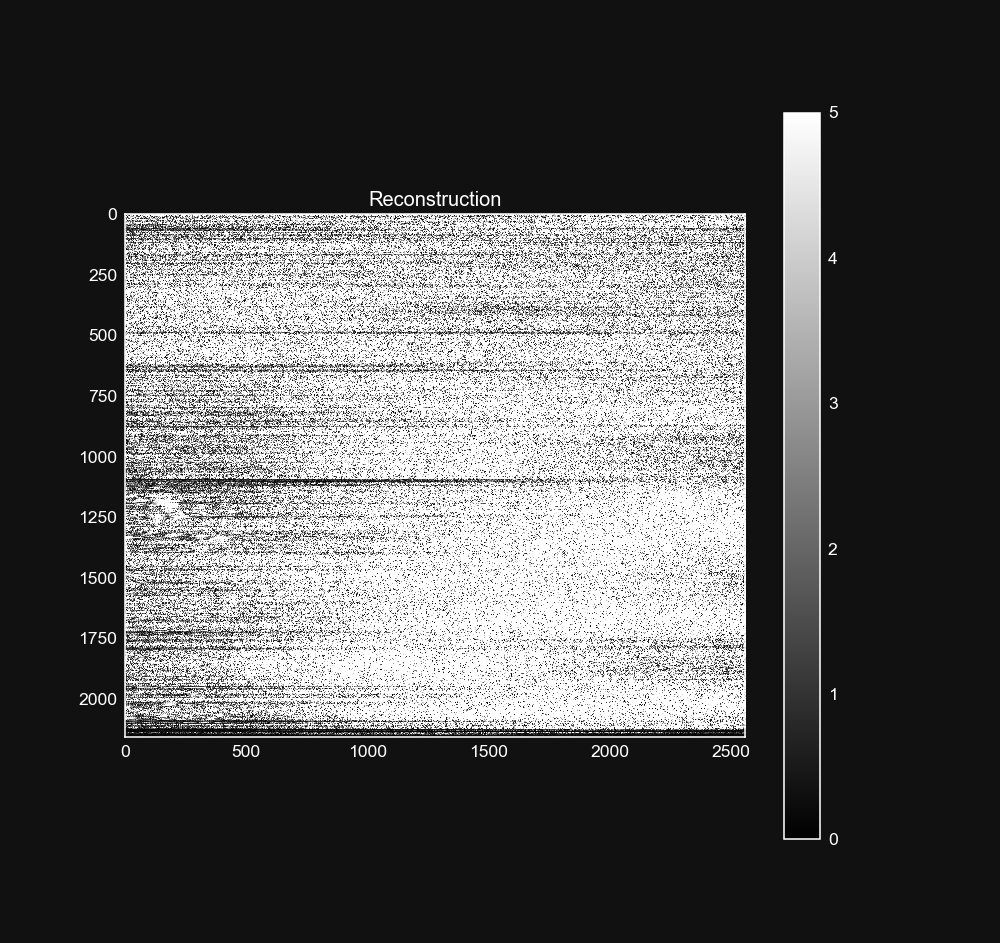

In [15]:
# Create recon object
recon = md.recon.Reconstruction(dataset, alpha_blend_distance=100, pad_mode=0, use_median_filter=True)

# Perform reconstruction
recon.reconstruct(iteration_count=100, step_size=1, frame_number=5, mode='single', reg_types={})

# Show result
recon.show()
plt.clim(0,5)

# recon.save(output_path, filename=recon.dataset.metadata.file_header + 'unreg_strip=' + str(dataset.motiondeblur.position_segment_indicies[0]), formats=['png', 'npz'], save_raw=True, downsample=4)

In [ ]:
plt.clim((0,5))

## Calculate SNR of Recon

In [ ]:
fig, ax_list = plt.subplots(1,2)

raw_signal_roi = yp.Roi(start=(1900,1250), shape=(25,25))
raw_noise_roi = yp.Roi(start=(1000,1675), shape=(100,100))
im = ax_list[0].imshow(recon.y, vmin=0.95, vmax=2)
# ax_list[0].set_clim((0,2))
raw_signal_roi.draw(ax_list[0], c='g')
raw_noise_roi.draw(ax_list[0], c='r')

recovered_noise_roi = yp.Roi(start=(1190,2450), shape=(100,100))
recovered_signal_roi = yp.Roi(start=(885,1756), shape=(5,5))
ax_list[1].imshow(recon.object_recovered, vmin=0.95, vmax=10)
# ax_list[1].set_clim((0,2))
recovered_signal_roi.draw(ax_list[1], c='g')
recovered_noise_roi.draw(ax_list[1], c='r')

snr_raw = noise.snr(recon.y, noise_roi=raw_noise_roi, signal_roi=raw_signal_roi)
snr_recovered = noise.snr(recon.object_recovered, noise_roi=recovered_noise_roi, signal_roi=recovered_signal_roi)

print(snr_raw)
print(snr_recovered)

## Crop for Figures

In [ ]:
coded_recovered_crop = recon.object_recovered[900:1050, 1200:1700]
measurement_crop = recon.y[900:1050, 1000:1500]

plt.figure()
plt.subplot(121)
plt.imshow(coded_recovered_crop)
# plt.clim((0,10))
plt.subplot(122)
plt.imshow(measurement_crop)
# plt.clim((0.9,2))

# Load Strobed Image

In [ ]:
dataset_path_strobe = '/Users/zfphil/datasets/motiondeblur/01-17-19-MotionDeblur/beads_strobe_raster_1_motion deblur_2019_01_17_18_49_23'

# Create dataset object (loads metadata)
dataset_strobe = Dataset(dataset_path_strobe, subtract_dark_current=True)#'res' not in dataset_label)

# Force type to be motiondeblur
dataset_strobe.metadata.type = 'motiondeblur'

# Generate recon object
recon_strobe = md.recon.Reconstruction(dataset_strobe, alpha_blend_distance=100, pad_mode=0, use_psf=False)

## Analyze SNR

In [ ]:
fig = plt.figure()
ax = plt.gca()
strobe_raw_signal_roi = yp.Roi(start=(100,100), shape=(250,250))
strobe_raw_noise_roi = yp.Roi(start=(0,0), shape=(1000,1000))
ax.imshow(recon_strobe.y_list[4], vmin=0, vmax=100)

strobe_raw_signal_roi.draw(ax, c='g')
strobe_raw_noise_roi.draw(ax, c='r')

snr_strobe = noise.snr(recon_strobe.y_list[4], noise_roi=strobe_raw_noise_roi, signal_roi=strobe_raw_signal_roi)
print(snr_strobe)

## Generate Cropped Inset for Figure

In [ ]:
strobe_crop = recon_strobe.y_list[4][900:1050, 400:900]

plt.figure(figsize=(6,2))
plt.imshow(strobe_crop)
plt.clim((0.9,1.5))

# Load Stop and Stare Data

In [ ]:
dataset_path_sns = '/Users/zfphil/datasets/motiondeblur/01-17-19-MotionDeblur/beads_stopandstare_raster_stop and stare_2019_01_17_18_41_50'

# Create dataset object (loads metadata)
dataset_sns = Dataset(dataset_path_sns, subtract_dark_current=False)#'res' not in dataset_label)

# Force type to be motiondeblur
dataset_strobe.metadata.type = 'motiondeblur'

recon_sns = md.recon.Reconstruction(dataset_sns, alpha_blend_distance=100, pad_mode=0, use_psf=False)

## Calculate SNR

In [ ]:
fig = plt.figure()
ax = plt.gca()
sns_raw_signal_roi = yp.Roi(start=(1306,1011), shape=(25,25))
sns_raw_noise_roi = yp.Roi(start=(0,0), shape=(500,500))
ax.imshow(recon_sns.y_list[4], vmin=0, vmax=100)

sns_raw_signal_roi.draw(ax, c='g')
sns_raw_noise_roi.draw(ax, c='r')

snr_sns = noise.snr(recon_sns.y_list[4], noise_roi=sns_raw_noise_roi, signal_roi=sns_raw_signal_roi, debug=True)
print(snr_sns)

## Generate Inset

In [ ]:
sns_crop = recon_sns.y_list[4][900:1050, 1170:1670]

plt.figure()
plt.subplot(121)
plt.imshow(coded_recovered_crop)
plt.clim((0,10))
plt.subplot(122)
plt.imshow(sns_crop)
# plt.clim((0.9,2))

## Save Figures

In [ ]:
plt.figure(figsize=(6,2))
plt.imshow(sns_crop)
plt.axis('off')
plt.tight_layout()
plt.savefig('sns.pdf', transparent=True)

plt.figure(figsize=(6,2))
plt.imshow(coded_recovered_crop)
plt.axis('off')
plt.tight_layout()
plt.clim((0,10))
plt.savefig('coded_recovered.pdf', transparent=True)

plt.figure(figsize=(6,2))
plt.imshow(measurement_crop)
plt.clim((0.9,2))
plt.axis('off')
plt.tight_layout()
plt.savefig('coded_raw.pdf', transparent=True)

plt.figure(figsize=(6,2))
plt.imshow(strobe_crop)
plt.clim((0.9,1.5))
plt.axis('off')
plt.tight_layout()
plt.savefig('strobe.pdf', transparent=True)

In [ ]:
!open .